# AI Training with Real-Time Tuning and Visualization (with asyncio)

This notebook demonstrates how Dear ImGui Bundle can be used in a Jupyter Notebook in order to provide a real-time interface
for tuning hyperparameters and visualizing the training process of a neural network.

**Features:**
- Live training loss visualization
- Adjustable hyperparameters during training (learning rate, momentum)
- Pause/resume training
- Training progress monitoring

We'll train a simple neural network on the classic **Iris dataset** using PyTorch.

In this example:

- we run the GUI in non-blocking mode using `immapp.nb.run()`. In this mode, the GUI is launched as an asyncio task.
- the training loop is also run as an asyncio task, allowing it to run concurrently with the GUI. It calls `await asyncio.sleep(0)` regularly to yield control back to the event loop, ensuring the GUI remains responsive.

_Note: for more demanding training tasks, consider running the training loop in a separate thread. See [notebook_ml_training_threaded.ipynb](notebook_ml_training_threaded.ipynb) for an example._

## Setup and Imports

First, let's install the required packages and import the necessary libraries.

In [10]:
# Install required packages (uncomment if needed)
# !pip install torch scikit-learn

from imgui_bundle import immapp, imgui, implot, hello_imgui
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import asyncio
import time

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Prepare the Dataset

Load and prepare the Iris dataset for training.

In [11]:
# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

print(f"✓ Dataset prepared")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Features: {X_train.shape[1]}")
print(f"  Classes: {len(np.unique(y))}")

✓ Dataset prepared
  Training samples: 120
  Test samples: 30
  Features: 4
  Classes: 3


## Define the Neural Network

Create a simple feedforward neural network for classification.

In [12]:
class IrisNet(nn.Module):
    def __init__(self, input_size=4, hidden_size=16, num_classes=3):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Initialize model
model = IrisNet()
criterion = nn.CrossEntropyLoss()

print("✓ Neural network created")
print(f"  Model: {model}")

✓ Neural network created
  Model: IrisNet(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
)


## Training State

Create a shared state object to hold training data and hyperparameters. This will be accessed by both the GUI and the training loop.

In [13]:
# Training state (shared between GUI and training loop)
training_state = {
    # Hyperparameters
    "learning_rate": 0.01,
    "momentum": 0.9,
    
    # Training data
    "losses": [],
    "accuracies": [],
    "test_accuracies": [],
    "epochs_completed": 0,
    "max_epochs": 10000,
    "max_points": 10000,  # Maximum points to show in plot
    
    # Control
    "paused": False,
    "reset_requested": False,
    "optimizer": None,  # Will be created when training starts
}

print("✓ Training state initialized")

✓ Training state initialized


## GUI Implementation

Define the GUI that displays training progress and allows hyperparameter adjustment.

In [14]:
def training_gui():
    """GUI that shows training progress and controls"""
    
    imgui.text("Neural Network Training Monitor")
    
    # Training info
    imgui.separator_text("Training info")
    imgui.text(f"Epoch: {training_state['epochs_completed']} / {training_state['max_epochs']}")
    
    if len(training_state['losses']) > 0:
        current_loss = training_state['losses'][-1]
        imgui.text(f"Current Loss: {current_loss:.4f}")
        
    if len(training_state['accuracies']) > 0:
        train_acc = training_state['accuracies'][-1]
        imgui.text(f"Train Accuracy: {train_acc:.2f}%")
        
    if len(training_state['test_accuracies']) > 0:
        test_acc = training_state['test_accuracies'][-1]
        imgui.text(f"Test Accuracy: {test_acc:.2f}%")
    
    imgui.separator()
    
    # Hyperparameters
    imgui.separator_text("Tune Hyperparameters")

    # max epochs slider
    changed, training_state["max_epochs"] = imgui.slider_int(
        "Max Epochs", 
        training_state["max_epochs"], 
        1, 50000
    )

    # Max points slider
    changed, training_state["max_points"] = imgui.slider_int(
        "Max Points in Plot", 
        training_state["max_points"], 
        100, 50000
    )
    
    # Learning rate slider
    changed, new_lr = imgui.slider_float(
        "Learning Rate", 
        training_state["learning_rate"], 
        0.0001, 0.1,
        format="%.4f",
        flags=imgui.SliderFlags_.logarithmic
    )
    if changed:
        training_state["learning_rate"] = new_lr
        # Update optimizer if it exists
        if training_state["optimizer"] is not None:
            for param_group in training_state["optimizer"].param_groups:
                param_group['lr'] = new_lr
    
    # Momentum slider
    changed, new_momentum = imgui.slider_float(
        "Momentum", 
        training_state["momentum"], 
        0.0, 0.99,
        format="%.2f"
    )
    if changed:
        training_state["momentum"] = new_momentum
        # Update optimizer if it exists
        if training_state["optimizer"] is not None:
            for param_group in training_state["optimizer"].param_groups:
                param_group['momentum'] = new_momentum
    

    imgui.separator_text("Controls")    
    # Control buttons
    if imgui.button("Pause" if not training_state["paused"] else "Resume"):
        training_state["paused"] = not training_state["paused"]
    
    imgui.same_line()
    if imgui.button("Reset Training"):
        training_state["reset_requested"] = True
    
    imgui.same_line()
    if imgui.button("Close"):
        hello_imgui.get_runner_params().app_shall_exit = True
    
    imgui.separator_text("Plots")
    
    # Plot training loss
    if len(training_state["losses"]) > 0:
        if implot.begin_plot("Training Loss", hello_imgui.em_to_vec2(40, 12)):
            implot.setup_axes("Epoch", "Loss", 
                            implot.AxisFlags_.auto_fit, 
                            implot.AxisFlags_.auto_fit)
            
            # Get data to plot
            losses = training_state["losses"][-training_state["max_points"]:]
            x_data = np.arange(len(losses), dtype=np.float32)
            y_data = np.array(losses, dtype=np.float32)
            
            implot.plot_line("Loss", x_data, y_data)
            implot.end_plot()
    
    # Plot accuracy
    if len(training_state["accuracies"]) > 0:
        if implot.begin_plot("Accuracy", hello_imgui.em_to_vec2(40, 12)):
            implot.setup_axes("Epoch", "Accuracy (%)", 
                            implot.AxisFlags_.auto_fit, 
                            implot.AxisFlags_.auto_fit)
            
            # Get data to plot
            train_accs = training_state["accuracies"][-training_state["max_points"]:]
            test_accs = training_state["test_accuracies"][-training_state["max_points"]:]
            x_data = np.arange(len(train_accs), dtype=np.float32)
            
            implot.plot_line("Train", x_data, np.array(train_accs, dtype=np.float32))
            implot.plot_line("Test", x_data, np.array(test_accs, dtype=np.float32))
            implot.end_plot()

print("✓ GUI defined")

✓ GUI defined


## Start the GUI

Launch the GUI in non-blocking mode, using `immapp.nb.start()`. The window will appear on top of your browser and will update in real-time as training progresses.

:::{important}
The GUI will open in a separate window on top of the browser. You won't see it embedded in the notebook.
By default, this window will stay on top of other windows (i.e., it is always on top) to allow easy access while working in the notebook.
:::

In [ ]:
# Start the GUI (non-blocking)
immapp.nb.start(
    training_gui,
    window_title="Neural Network Training",
    window_size=(900, 700),
    with_implot=True,
    # top_most=False  # Uncomment to disable always-on-top behavior
)

print("✓ GUI started!")
print("✓ Run the next cell to start training.")

✓ GUI started!
✓ Run the next cell to start training.


## Run the Training Loop

This cell runs the actual training loop. The model trains for the specified number of epochs, and you can see the loss curve updating in real-time in the GUI window.

**While training:**
- Adjust the learning rate or momentum sliders to see how they affect training
- Pause and resume training
- Reset training to start over

:::{note}
This cell will run for several seconds. The training loop calls `await asyncio.sleep(0)` to yield control to the event loop, allowing the GUI to update smoothly.
:::

In [19]:
async def train_model():
    """Training loop that updates GUI in real-time"""
    global model, criterion
    
    print("Starting training...")
    
    # Create optimizer
    training_state["optimizer"] = optim.SGD(
        model.parameters(),
        lr=training_state["learning_rate"],
        momentum=training_state["momentum"]
    )
    
    epoch = 0
    
    while epoch < training_state["max_epochs"]: # and immapp.nb.is_running():
        # Check if reset requested
        if training_state["reset_requested"]:
            print("Resetting training...")
            model = IrisNet()  # Reinitialize model
            training_state["losses"].clear()
            training_state["accuracies"].clear()
            training_state["test_accuracies"].clear()
            training_state["epochs_completed"] = 0
            training_state["optimizer"] = optim.SGD(
                model.parameters(),
                lr=training_state["learning_rate"],
                momentum=training_state["momentum"]
            )
            training_state["reset_requested"] = False
            epoch = 0
            continue
        
        # Skip if paused
        if training_state["paused"]:
            await asyncio.sleep(0.1)
            continue
        
        # Training step
        model.train()
        training_state["optimizer"].zero_grad()
        
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        # Backward pass
        loss.backward()
        training_state["optimizer"].step()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_acc = (predicted == y_train_tensor).sum().item() / len(y_train_tensor) * 100
        
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_acc = (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor) * 100
        
        # Update training state
        training_state["losses"].append(loss.item())
        training_state["accuracies"].append(train_acc)
        training_state["test_accuracies"].append(test_acc)
        training_state["epochs_completed"] = epoch + 1
        
        # Keep buffer size limited
        if len(training_state["losses"]) > training_state["max_points"]:
            training_state["losses"].pop(0)
            training_state["accuracies"].pop(0)
            training_state["test_accuracies"].pop(0)
        
        epoch += 1
        
        # Yield control to event loop (allows GUI to update)
        # (Call this more often if you want a more responsive GUI)
        await asyncio.sleep(0)
        
        # Print progress every 50 epochs
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss={loss.item():.4f}, Train Acc={train_acc:.2f}%, Test Acc={test_acc:.2f}%")
    
    print(f"✓ Training completed!")
    print(f"  Final Loss: {training_state['losses'][-1]:.4f}")
    print(f"  Final Train Accuracy: {training_state['accuracies'][-1]:.2f}%")
    print(f"  Final Test Accuracy: {training_state['test_accuracies'][-1]:.2f}%")

# Run the training loop
await train_model()

Starting training...
Epoch 50: Loss=0.0406, Train Acc=98.33%, Test Acc=100.00%
Epoch 100: Loss=0.0406, Train Acc=98.33%, Test Acc=100.00%
Epoch 150: Loss=0.0405, Train Acc=98.33%, Test Acc=100.00%
Epoch 200: Loss=0.0405, Train Acc=98.33%, Test Acc=100.00%
Epoch 250: Loss=0.0405, Train Acc=98.33%, Test Acc=100.00%
Epoch 300: Loss=0.0404, Train Acc=98.33%, Test Acc=100.00%
Epoch 350: Loss=0.0404, Train Acc=98.33%, Test Acc=100.00%
Epoch 400: Loss=0.0403, Train Acc=98.33%, Test Acc=100.00%
Epoch 450: Loss=0.0403, Train Acc=98.33%, Test Acc=100.00%
Epoch 500: Loss=0.0402, Train Acc=98.33%, Test Acc=100.00%
Epoch 550: Loss=0.0402, Train Acc=98.33%, Test Acc=100.00%
Epoch 600: Loss=0.0401, Train Acc=98.33%, Test Acc=100.00%
Epoch 650: Loss=0.0401, Train Acc=98.33%, Test Acc=100.00%
Epoch 700: Loss=0.0401, Train Acc=98.33%, Test Acc=100.00%
Epoch 750: Loss=0.0400, Train Acc=98.33%, Test Acc=100.00%
Epoch 800: Loss=0.0400, Train Acc=98.33%, Test Acc=100.00%
Epoch 850: Loss=0.0399, Train Acc=98

## Experiment with Hyperparameters

While the training is running, you can:

1. **Adjust the learning rate** - Try increasing it to see faster convergence (but possibly less stable), or decreasing it for more stable but slower training.

2. **Modify momentum** - Change the momentum parameter to see how it affects training dynamics.

3. **Pause and resume** - Pause training, adjust parameters, then resume.

4. **Reset training** - Click "Reset Training" to start from scratch with new hyperparameters.

Try running the training cell again and experimenting with different values!

## Check Training Status

You can check if the training is still running:

In [9]:
immapp.nb.is_running()

True

## Stop the GUI

When you're done, stop the GUI:

In [10]:
immapp.nb.stop()

## Evaluate the Trained Model

After training, you can evaluate the final model performance:

In [20]:
# Final evaluation
model.eval()
with torch.no_grad():
    # Training set
    train_outputs = model(X_train_tensor)
    _, train_predicted = torch.max(train_outputs.data, 1)
    train_accuracy = (train_predicted == y_train_tensor).sum().item() / len(y_train_tensor) * 100
    
    # Test set
    test_outputs = model(X_test_tensor)
    _, test_predicted = torch.max(test_outputs.data, 1)
    test_accuracy = (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor) * 100

print("=" * 50)
print("FINAL MODEL PERFORMANCE")
print("=" * 50)
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print("=" * 50)

# Show confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_tensor.numpy(), test_predicted.numpy())
print("\nConfusion Matrix (Test Set):")
print(cm)
print(f"\nClass names: {iris.target_names}")

FINAL MODEL PERFORMANCE
Training Accuracy: 98.33%
Test Accuracy: 100.00%

Confusion Matrix (Test Set):
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]

Class names: ['setosa' 'versicolor' 'virginica']


# Run the GUI to show a screenshot in the notebook

We can run the GUI one last time to capture a screenshot for display in the notebook. 

This time, we run it in blocking mode (using `immapp.nb.run()`) for a few seconds to take the screenshot.

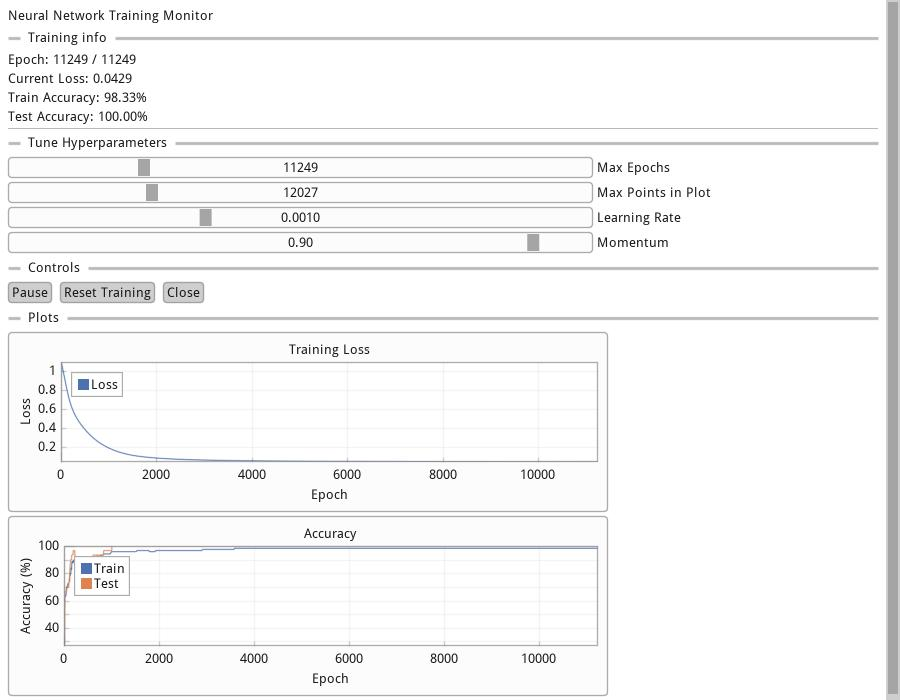

In [22]:
immapp.nb.run(
    training_gui,
    window_title="Neural Network Training",
    window_size=(900, 700),
    with_implot=True
)

## Summary

This notebook demonstrated:

✓ **Real-time training visualization** - Loss and accuracy curves updated live during training

✓ **Interactive hyperparameter tuning** - Adjusted learning rate and momentum on-the-fly

✓ **Async training loop** - Used `await asyncio.sleep(0)` to yield control and keep GUI responsive

✓ **Training control** - Paused, resumed, and reset training from the GUI

This pattern can be extended to more complex scenarios:
- Larger datasets and deeper networks
- Additional hyperparameters (batch size, learning rate schedules, etc.)
- Multiple metrics (precision, recall, F1-score)
- Training on GPU
- Saving/loading checkpoints during training

The key is the non-blocking async pattern: the GUI runs in one task while the training loop runs in another, both cooperating through shared state.

See [notebook_ml_training_threaded.ipynb](notebook_ml_training_threaded.ipynb) for an example using threading for the training loop instead of asyncio.